## Проект - Снижение затрат на электроэнергию при обработке стали

### План работы над проектом

**1.Исследовательский анализ данных** 
- загрузить данные
- проверить данные на пропуски, дубликаты, типы данных, выбросы / аномалии

**2. Уточнить задачу проекта на основе анализа**

**3. Предобработка данных**
- дополнить данные расчетами
- объединить данные в один датафрейм
- подготовить данные для работы над проектом (очистить от пропусков и выбросов)
- исключить ненужные данные

**4. Подготовка данных для обучения**
- выделение выборок обучающей и тестовой
- определение необходимых признаков для построения модели (целевой признак: конечная температура стали каждой партии)

**5. Обучение и тестирование модели**
- выбор моделей для обучения
- обучение моделей
- проверка качества моделей по скорости обучения и качеству метрики
- проверка моделей на тестовой выборки
- выбор лучшей модели

**6. Заключение / отчет по проекту и достижению цели**

### Метрика проекта

**Метрика качества: MAE**

**Критерии оценки проекта:**
<br> MAE > 8.7 — 0 sp
<br> 6 ≤ MAE ≤ 8.7 — 4 - 5.9 sp
<br> MAE < 6.0 — 6 sp

## Исследовательский анализ данных

### Загрузка данных

Импортируем необходимые библиотеки для работы над проектом

In [59]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import time as tm

Загрузим данные проекта

In [60]:
DS = '/datasets/final_steel/'

In [61]:
arc = pd.read_csv(DS + 'data_arc.csv')
bulk = pd.read_csv(DS + 'data_bulk.csv')
bulk_time = pd.read_csv(DS + 'data_bulk_time.csv')
gas = pd.read_csv(DS + 'data_gas.csv')
temp = pd.read_csv(DS + 'data_temp.csv')
wire = pd.read_csv(DS + 'data_wire.csv')
wire_time = pd.read_csv(DS + 'data_wire_time.csv')

### Анализ данных

#### Данные об электродах

In [62]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [63]:
arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [64]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


По электродам пропусков нет, есть странные отрицательные значения в реактивной мощности (аномальные значения отбросим при обработке)

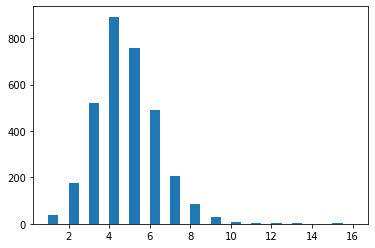

In [65]:
# построим гистограмму по кол-ву партий
plt.hist((list(arc['key'].value_counts())), bins=30)
plt.show()

In [66]:
arc['key'].value_counts().describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

Кол-во партий - 3214. 
<br> Кол-во интераций обработок партии от 1 до 16, среднее кол-во обработок - 4,6

#### Данные о подаче сыпучих материалов (объём)

In [67]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [68]:
# посчитаем пропуски в процентах от всех записей
bulk.isna().mean().sort_values().round(3)*100

key          0.0
Bulk 14     10.3
Bulk 12     21.7
Bulk 15     28.2
Bulk 3      58.5
Bulk 4      67.6
Bulk 6      81.6
Bulk 1      91.9
Bulk 11     94.3
Bulk 10     94.4
Bulk 5      97.5
Bulk 7      99.2
Bulk 2      99.3
Bulk 9      99.4
Bulk 13     99.4
Bulk 8     100.0
dtype: float64

In [69]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [70]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Кол-во партий - 3129 (что меньше на 85 в сравнении с записями по электродам). 
<br> Очень много пропусков в данных, это может быть связано с технологическим процессом (добавляется разное кол-во легирующих материалов). Пропуски можно будет заполнить нулями.

#### Данные о подаче сыпучих материалов (время)

In [71]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [72]:
# посчитаем пропуски в процентах от всех записей
bulk_time.isna().mean().sort_values().round(3)*100

key          0.0
Bulk 14     10.3
Bulk 12     21.7
Bulk 15     28.2
Bulk 3      58.5
Bulk 4      67.6
Bulk 6      81.6
Bulk 1      91.9
Bulk 11     94.3
Bulk 10     94.4
Bulk 5      97.5
Bulk 7      99.2
Bulk 2      99.3
Bulk 9      99.4
Bulk 13     99.4
Bulk 8     100.0
dtype: float64

In [73]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [74]:
bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Пропуски по времени аналогичны с данными по объему сыпучих материалов.
<br> Тип данных нужно будет скорректировать на `datetime`

#### Данные о продувке сплава газом

In [75]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [76]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [77]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [78]:
gas['key'].value_counts().describe()

count    3239.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: key, dtype: float64

Пропуски и отклонения отсутствуют. 
<br> Нет данных по 2м партиям.
<br> Газом продувается каждая партия.

#### Результаты измерения температуры

In [79]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [80]:
temp.isna().mean().sort_values().round(3)*100

key              0.0
Время замера     0.0
Температура     18.2
dtype: float64

In [81]:
temp.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [82]:
temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


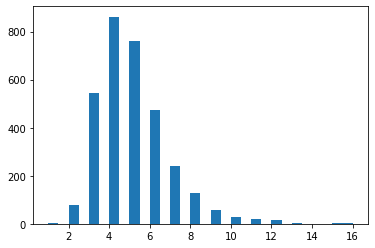

In [83]:
plt.hist((list(temp['key'].value_counts())), bins=30)
plt.show()

In [84]:
temp['key'].value_counts().describe()

count    3216.000000
mean        4.946206
std         1.793169
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: key, dtype: float64

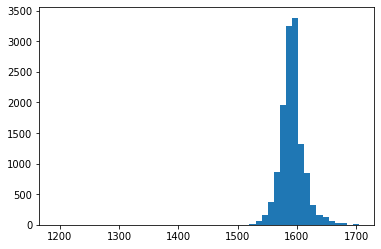

In [85]:
plt.hist((list(temp['Температура'])), bins=50)
plt.show()

Есть пропуски - 18% по температуре, придется их отбросить, т.к. температура является целевым признаком
<br>Замеряемая температура находится в диапазоне от 1500 до 1705
<br>Для модели нам важны только начальная и конечная температуры, промежуточные замеры можно будет удалить.

#### Данные о проволочных материалах (объём)

In [86]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [87]:
wire.isna().mean().sort_values().round(3)*100

key         0.0
Wire 1      0.8
Wire 2     65.0
Wire 6     97.6
Wire 3     98.0
Wire 9     99.1
Wire 8     99.4
Wire 4     99.5
Wire 7     99.6
Wire 5    100.0
dtype: float64

In [88]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Большое кол-во пропусков, что также может быть связано с тех.процессом.

#### Данные о проволочных материалах (время)

In [90]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [91]:
wire_time.isna().mean().sort_values().round(3)*100

key         0.0
Wire 1      0.8
Wire 2     65.0
Wire 6     97.6
Wire 3     98.0
Wire 9     99.1
Wire 8     99.4
Wire 4     99.5
Wire 7     99.6
Wire 5    100.0
dtype: float64

In [92]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Аналогичные пропуск, как и по объему.
<br>Тип данных нужно будет скорректировать на `datetime`

#### Выводы

1. Данные содержат пропуски, которые можно заполнить нулями (по сыпучим и проволочным материалам)
2. Пропуски с целевым признаком (температурой) стоит удалить, не имея возможности заполнить их корректно
3. Тип временных данных нужно изменить на тип `datetime`
4. Все данные (очищенные и подготовленные) стоит объеденить в один датасет по ключевому столбцу `key` с номером партии

## Предобработка данных

### Дополнительные расчеты

#### Температура

In [94]:
# изменим тип данных
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

In [95]:
# выделим начальную и конечную температуры и вытащим данные в новую таблицу
first_temp = pd.merge(temp.groupby('key')['Время замера'].agg('min'), temp, how="left", on="Время замера")
last_temp = pd.merge(temp.groupby('key')['Время замера'].agg('max'), temp, how="left", on="Время замера")
data = pd.merge(first_temp[['key','Температура']], last_temp[['key','Температура']], how="outer", on="key")
data = data.rename(columns={'Температура_x': 'first_temp', 'Температура_y': 'last_temp'})

In [96]:
# расчитаем длительность времени между первым и последним замером температуры
data = pd.merge(data, temp[['key','Время замера']].groupby('key')['Время замера']
                .agg(lambda x: x.max()-x.min()).dt.total_seconds(), how='left', on='key')
data = data.rename(columns={'Время замера': 'cycle_time'})
data.head()


,key,first_temp,last_temp,cycle_time
0,1,1571.0,1613.0,861.0
1,2,1581.0,1602.0,1305.0
2,3,1596.0,1599.0,1300.0
3,4,1601.0,1625.0,388.0
4,5,1576.0,1602.0,762.0


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3216 non-null   int64  
 1   first_temp  3216 non-null   float64
 2   last_temp   2477 non-null   float64
 3   cycle_time  3216 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 125.6 KB


In [98]:
data.describe()

,key,first_temp,last_temp,cycle_time
count,3216.000000,3216.000000,2477.000000,3216.000000
mean,1622.199316,1588.592040,1595.334275,1839.861629
std,935.088523,29.137454,16.019339,1246.950298
min,1.000000,1191.000000,1541.000000,0.000000
25%,815.750000,1572.000000,1587.000000,1177.000000
50%,1622.500000,1588.000000,1593.000000,1581.000000
75%,2431.250000,1606.000000,1599.000000,2235.000000
max,3241.000000,1684.000000,1700.000000,23537.000000


Таблица создана с начальной и конечной температурами и длительностью времени между замерами

#### Время нагрева электродами и кол-во нагревов

In [99]:
# удалим записи с отрицательной реактивной мощностью
arc = arc[arc['Реактивная мощность'] > 0]

In [100]:
# изменим тип данных
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

In [101]:
# расчитаем время нагрева и количество нагревов
arc['Время нагрева'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds()
arc_1 = arc[['key','Время нагрева']].groupby('key', as_index=False).agg(['sum','count'])
arc_1.columns = ['Время нагрева', 'Кол-во нагревов']
arc_1.head()

,Время нагрева,Кол-во нагревов
key,,
1,1098.0,5
2,811.0,4
3,655.0,5
4,741.0,4
5,869.0,4


In [102]:
# добавим данные в нашу новую таблицу
data = pd.merge(data, arc_1, how='left', on='key')
data.head()

,key,first_temp,last_temp,cycle_time,Время нагрева,Кол-во нагревов
0,1,1571.0,1613.0,861.0,1098.0,5.0
1,2,1581.0,1602.0,1305.0,811.0,4.0
2,3,1596.0,1599.0,1300.0,655.0,5.0
3,4,1601.0,1625.0,388.0,741.0,4.0
4,5,1576.0,1602.0,762.0,869.0,4.0


#### Среднее соотношение потребления активной и реактивной мощности

In [103]:
# расчитаем отношение активной мощности к реактивной
arc['Соотношение мощностей'] = arc['Реактивная мощность'] / arc['Активная мощность']

In [104]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Соотношение мощностей
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,0.703937
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,0.645830
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,0.670110
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,0.640408
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,0.598188


In [105]:
# расчитаем среднее соотношение
arc_2 = arc[['key','Соотношение мощностей']].groupby('key', as_index=False).agg(['median'])
arc_2.columns = ['Среднее соотношение мощностей']
arc_2.head()

,Среднее соотношение мощностей
key,
1,0.645830
2,0.635281
3,0.632261
4,0.624417
5,0.667329


In [106]:
# добавим значения в наш датасет
data = pd.merge(data, arc_2, how='left', on='key')
data.head()

,key,first_temp,last_temp,cycle_time,Время нагрева,Кол-во нагревов,Среднее соотношение мощностей
0,1,1571.0,1613.0,861.0,1098.0,5.0,0.645830
1,2,1581.0,1602.0,1305.0,811.0,4.0,0.635281
2,3,1596.0,1599.0,1300.0,655.0,5.0,0.632261
3,4,1601.0,1625.0,388.0,741.0,4.0,0.624417
4,5,1576.0,1602.0,762.0,869.0,4.0,0.667329


In [107]:
data['Среднее соотношение мощностей'].describe()

count    3214.000000
mean        0.739504
std         0.094250
min         0.527969
25%         0.684551
50%         0.722446
75%         0.771296
max         1.690754
Name: Среднее соотношение мощностей, dtype: float64

#### Вывод

1. выделили в данных целевой признак - конечную температура
2. создали новые признаки, которые будут использоваться в обучении и предстказании модели

### Объединение данных

Объеденим данные в один датасет, после чего будет обрабатывать их. Данные со временем добавления проволоки и сыпучих материалов добавлять не будем в итоговый датасет, не нужны для расчетов модели.

In [108]:
data = pd.merge(data, arc[['key', 'Активная мощность','Реактивная мощность']].groupby('key').sum(), how="left", on=["key"])
data = pd.merge(data, gas, how="left", on=["key"])
data = pd.merge(data, wire, how="left", on=["key"])
data = pd.merge(data, bulk, how="left", on=["key"])
data = data.set_index('key')
data.head(5)


,first_temp,last_temp,cycle_time,Время нагрева,Кол-во нагревов,Среднее соотношение мощностей,Активная мощность,Реактивная мощность,Газ 1,Wire 1,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5.0,0.645830,4.878147,3.183241,29.749986,60.059998,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,1581.0,1602.0,1305.0,811.0,4.0,0.635281,3.052598,1.998112,12.555561,96.052315,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,1596.0,1599.0,1300.0,655.0,5.0,0.632261,2.525882,1.599076,28.554793,91.160157,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,1601.0,1625.0,388.0,741.0,4.0,0.624417,3.209250,2.060298,18.841219,89.063515,...,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,1576.0,1602.0,762.0,869.0,4.0,0.667329,3.347173,2.252643,5.413692,89.238236,...,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Столбцы имеют разный вид написания, исправим это

In [109]:
data.columns

Index(['first_temp', 'last_temp', 'cycle_time', 'Время нагрева',
       'Кол-во нагревов', 'Среднее соотношение мощностей', 'Активная мощность',
       'Реактивная мощность', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [110]:
# переименуем столбцы
data=data.rename(columns={'Время нагрева': 'heating_time', 'Кол-во нагревов': 'heating_count'
                          , 'Газ 1': 'gas 1', 'Активная мощность': 'active_power',
                          'Реактивная мощность': 'reactive_power',
                          'Среднее соотношение мощностей': 'power_ratio_median'})

In [111]:
# приведем названия столбцов к нижнему регистру и заменим пробелы на подчеркивание
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(" ", "_")

In [112]:
data.head(5)

,first_temp,last_temp,cycle_time,heating_time,heating_count,power_ratio_median,active_power,reactive_power,gas_1,wire_1,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5.0,0.645830,4.878147,3.183241,29.749986,60.059998,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,1581.0,1602.0,1305.0,811.0,4.0,0.635281,3.052598,1.998112,12.555561,96.052315,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,1596.0,1599.0,1300.0,655.0,5.0,0.632261,2.525882,1.599076,28.554793,91.160157,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,1601.0,1625.0,388.0,741.0,4.0,0.624417,3.209250,2.060298,18.841219,89.063515,...,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,1576.0,1602.0,762.0,869.0,4.0,0.667329,3.347173,2.252643,5.413692,89.238236,...,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temp          3216 non-null   float64
 1   last_temp           2477 non-null   float64
 2   cycle_time          3216 non-null   float64
 3   heating_time        3214 non-null   float64
 4   heating_count       3214 non-null   float64
 5   power_ratio_median  3214 non-null   float64
 6   active_power        3214 non-null   float64
 7   reactive_power      3214 non-null   float64
 8   gas_1               3214 non-null   float64
 9   wire_1              3055 non-null   float64
 10  wire_2              1079 non-null   float64
 11  wire_3              63 non-null     float64
 12  wire_4              14 non-null     float64
 13  wire_5              1 non-null      float64
 14  wire_6              73 non-null     float64
 15  wire_7              11 non-null     float64
 16  wire_8

в данных остались пропуски, обработаем их далее

### Обработка пропусков

In [114]:
# отбросим пустые значения с конечной температурой, газом и мощностью
data=data.dropna(subset=['last_temp', 'gas_1', 'active_power'])

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temp          2473 non-null   float64
 1   last_temp           2473 non-null   float64
 2   cycle_time          2473 non-null   float64
 3   heating_time        2473 non-null   float64
 4   heating_count       2473 non-null   float64
 5   power_ratio_median  2473 non-null   float64
 6   active_power        2473 non-null   float64
 7   reactive_power      2473 non-null   float64
 8   gas_1               2473 non-null   float64
 9   wire_1              2346 non-null   float64
 10  wire_2              833 non-null    float64
 11  wire_3              39 non-null     float64
 12  wire_4              12 non-null     float64
 13  wire_5              0 non-null      float64
 14  wire_6              45 non-null     float64
 15  wire_7              4 non-null      float64
 16  wire_8

In [116]:
# заполним нулями оставшиеся пропуски, т.к. они связаны скорее всего с технологическим процессом
data = data.fillna(0)

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temp          2473 non-null   float64
 1   last_temp           2473 non-null   float64
 2   cycle_time          2473 non-null   float64
 3   heating_time        2473 non-null   float64
 4   heating_count       2473 non-null   float64
 5   power_ratio_median  2473 non-null   float64
 6   active_power        2473 non-null   float64
 7   reactive_power      2473 non-null   float64
 8   gas_1               2473 non-null   float64
 9   wire_1              2473 non-null   float64
 10  wire_2              2473 non-null   float64
 11  wire_3              2473 non-null   float64
 12  wire_4              2473 non-null   float64
 13  wire_5              2473 non-null   float64
 14  wire_6              2473 non-null   float64
 15  wire_7              2473 non-null   float64
 16  wire_8

In [118]:
print('Кол-во дубликатов:', data.duplicated().sum())

Кол-во дубликатов: 0


**Вывод:** Пропуски обработали. Дубликатов в данных нет.

## Создание выборок

Создадим признаки и выделим обучающую и тестовую выборки в соотношении 75:25

In [119]:
# выделим признаки
target = data['last_temp']
features = data.drop('last_temp', axis=1)

# разделим выборки на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=12345)

<font color='steelblue'><b>Комментарий ревьюера: </b></font> ✔️ <br>
<font color='green'>Выборки готовы.</font>

Масштабируем выборки

In [120]:
scaler = StandardScaler()
scaler.fit_transform(features_train)
features_train_lr = scaler.transform(features_train)
features_test_lr = scaler.transform(features_test)

## Обучение и выбор лучшей модели

### Константная модель

In [63]:
constant_model = DummyRegressor(strategy='mean')
constant_model.fit(features_train,target_train)
constant_pred = constant_model.predict(features_test)
print('MAE константной модели:', mean_absolute_error(target_test,constant_pred).round(2))

MAE константной модели: 9.31


### LinearRegression

In [64]:
start = tm.time()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid_lr = GridSearchCV(LinearRegression(), parameters, cv=5, scoring='neg_mean_absolute_error')
grid_lr.fit(features_train_lr, target_train)
mae_lr = abs(grid_lr.best_score_).round(2)
time_lr = tm.time() - start
print('MAE - LinearRegression: ', mae_lr)
params_lr = grid_lr.best_params_
print(params_lr)
print('training time -', time_lr, 'sec')

MAE - LinearRegression:  8.18
{'fit_intercept': True, 'normalize': True}
training time - 2.788100242614746 sec


### DecisionTreeRegressor

In [65]:
tree_params = {'max_depth': [2, 4, 6],
               'min_samples_split': [2, 5, 8, 10]}

In [66]:
start = tm.time()
grid_dtr = GridSearchCV(DecisionTreeRegressor(random_state=12345), 
                        tree_params, refit=False, cv=5, scoring='neg_mean_absolute_error') 
grid_dtr.fit(features_train, target_train)
mae_dtr = abs(grid_dtr.best_score_).round(2)
time_dtr = tm.time() - start
print('MAE - DecisionTreeRegressor: ', mae_dtr)
params_dtr = grid_dtr.best_params_
print(params_dtr)
print('training time -', time_dtr, 'sec')

MAE - DecisionTreeRegressor:  7.43
{'max_depth': 6, 'min_samples_split': 2}
training time - 0.9822602272033691 sec


### RandomForestRegressor

In [67]:
tree_params = {'n_estimators': [200], 
               'max_depth': [2, 4, 6],
               'min_samples_split': [2, 5, 8, 10]}

In [68]:
start = tm.time()
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=12345), 
                        tree_params, refit=False, cv=5, scoring='neg_mean_absolute_error') 
grid_rfr.fit(features_train, target_train)
mae_rfr = abs(grid_rfr.best_score_).round(2)
time_rfr = tm.time() - start
print('MAE - RandomForestRegressor: ', mae_rfr)
params_rfr = grid_rfr.best_params_
print(params_rfr)
print('training time -', time_rfr, 'sec')

MAE - RandomForestRegressor:  6.71
{'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 200}
training time - 55.08039450645447 sec


### CatBoostRegressor

In [69]:
param_grid_ctb = {'n_estimators': [300],  
                  'learning_rate': [0.03, 0.1, 0.15],
                  'depth': [4, 6]}

In [70]:
start = tm.time()
grid_ctb = GridSearchCV(CatBoostRegressor(random_state=12345, silent=True), 
                    param_grid_ctb, cv=5, scoring='neg_mean_absolute_error') 
grid_ctb.fit(features_train, target_train)
mae_cbr = abs(grid_ctb.best_score_).round(2)
time_cbr = tm.time() - start
print('MAE - CatBoostRegressor: ', mae_cbr)
params_cbr = grid_ctb.best_params_
print(params_cbr)
print('training time -', time_cbr, 'sec')

MAE - CatBoostRegressor:  5.67
{'depth': 6, 'learning_rate': 0.1, 'n_estimators': 300}
training time - 59.850666522979736 sec


### Выбор модели

Сравним расчеты по каждой модели

In [71]:
models = [['LR', mae_lr, time_lr, params_lr], 
          ['DTR', mae_dtr, time_dtr, params_dtr],
          ['RFR', mae_rfr, time_rfr, params_rfr],
          ['CBR', mae_cbr, time_cbr, params_cbr]]
    
df = pd.DataFrame(models, columns =['model', 'MAE', 'training_time, sec', 'parametrs']) 
df 


,model,MAE,"training_time, sec",parametrs
0,LR,8.18,2.788100,"{'fit_intercept': True, 'normalize': True}"
1,DTR,7.43,0.982260,"{'max_depth': 6, 'min_samples_split': 2}"
2,RFR,6.71,55.080395,"{'max_depth': 6, 'min_samples_split': 2, 'n_es..."
3,CBR,5.67,59.850667,"{'depth': 6, 'learning_rate': 0.1, 'n_estimato..."


**Вывод -** лучшей моделью является CatBoostRegressor с метрикой MAE = 5.67 на обучающей выборке, обучается за 60 сек.

### Проверка на тестовой выборке

Проверим лучшую модель на тестовой выборке

In [72]:
start = tm.time()
ctb = CatBoostRegressor(**params_cbr, random_state=12345, silent=True)
ctb.fit(features_train, target_train)
pred_test = ctb.predict(features_test)
time_cbr_test = tm.time() - start
mae_ctb_test = mean_absolute_error(target_test, pred_test).round(2)
print("MAE на тестовой выборке: ", mae_ctb_test)
print('testing time -', time_cbr_test, 'sec')

MAE на тестовой выборке:  5.37
testing time - 1.9333562850952148 sec


Посмотрим на графике качество предсказания

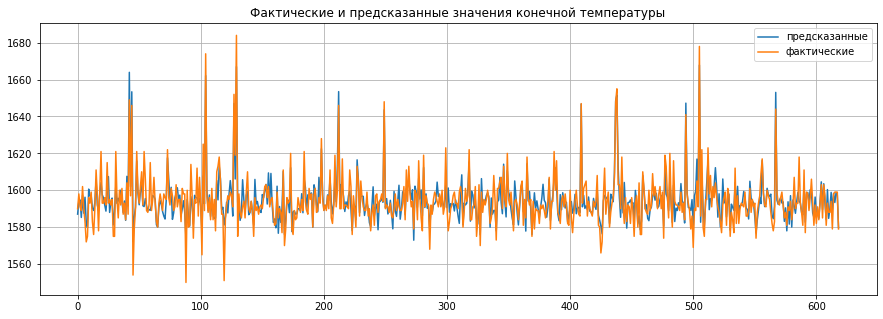

In [73]:
plt.figure(figsize=(15, 5))
plt.plot(ctb.predict(features_test), label="предсказанные")
plt.plot(target_test.values, label="фактические")
plt.legend(loc="best")
plt.title('Фактические и предсказанные значения конечной температуры')
plt.grid(True);

Посмотрим как показатели влияют на целевой признак

<Figure size 720x504 with 0 Axes>

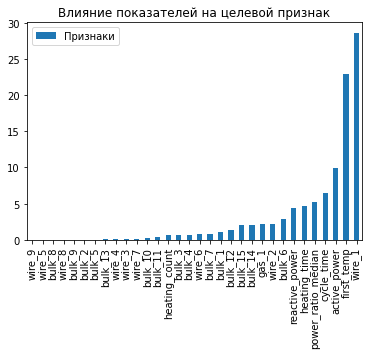

In [74]:
feature_importance = pd.DataFrame(ctb.feature_importances_, index=features.columns).sort_values(0)

plt.figure(figsize = (10, 7))
feature_importance.plot.bar()
plt.title('Влияние показателей на целевой признак')
plt.legend(labels=['Признаки']);

## Вывод

В ходе проекта:
1. были загружены и проанализированы данные, выявлены пропуски и откронения по реактивной мощности
2. в данные были добавлены новые признаки для обучения моделей, выделен целевой признак - конечная температура
3. пропуски и аномальные значения были обработаны:
- записи, где не было целевого признака были удалены, как и записи с аномальным значением по реактивной мощности
- остальные пропуски были заменены на нули
4. в результате итоговый датасет был сформирован из записей по 2473 партий
5. для выбора были обучены 4 модели: `LinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`, `CatBoostRegressor`
6. Лучшую MAE с кросс-валидаций показала модель `CatBoostRegressor` = **5.67**. Гиперпараметры: 'depth': 6, 'learning_rate': 0.1, 'n_estimators': 300
7. на тестовой выборке MAE = 5.37. В результате предсказанные значения конечной температуры по модели `CatBoostRegressor` на тестовой выборке близки к фактическим данным.

## Отчет по проекту

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

В ходе работы были выполнены все пункты первоначального плана:
1. загружены данные и проведен исследовательский анализ данных, определены аномалии и пропуски;
2. уточнена задачу проекта на основе анализа, определена метрика MAE для оценки качества модели;
3. далее проведена предобработка данных, в ходе которой было выполнено следующее:
- в датасет были включены дополнительные расчеты, которые использовались в качестве доп.признаков для обучения модели:
  - выделена начальная и конечные температуры (целевой признак);
  - время нагрева сплава и кол-во нагревов;
  - среднее соотношение потребления активной и реактивной мощности.
- данные были объеденены в один датасет, после чего была проведена обработка пропусков: 
  - удалены аномальные значения по реактивной мощности (отрицательные);
  - удалены записи с пропусками по конечной температуре, газу и мощностью;
  - остальные пропуски были заполнены нулями, т.к. связаны с технологическим процессом.
<br> Наиболее важными признаками, влияющими в наибольшей мере на целевой признак являются: начальная температура, проволока 1,которая добавляется в 99.2% сплавов, и активная мощность, используемая для тех.процесса.
4. подготовлены данные для обучения (целевой признак - конечная температура, признаки для обучения - все остальные, далее данные были разбиты на обучающую и тестовую выборки в соотношении 75 / 25)
5. были обучены 4 модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor, с применением кросс-валидации и на основании наименьшей метрики MAE выбрана лучшая модель, которая протестирована на тестовой выборке

**Какие трудности возникли и как вы их преодолели?**

Возникли небольшие трудности при объединении данных в один датасет с минимальной потерей данных (ошибка была при обработке пропусков - не все данные были корректно откинуты). Ошибка была исправлена после проверки тимлида.

**Какие ключевые шаги в решении задачи выделили?**

1. Анализ данных на поиск пропусков и аномалий
2. Обработка и подготовка данных
3. Подготовка признаков и выборок
4. Выбор и обучение моделей
5. Выбор лучшей модели и проверка ее на тестовых данных

**Какая ваша итоговая модель и какое у неё качество?**

Итоговой модель выбрана `CatBoostRegressor` с метрикой MAE = 5.67 с кросс-валидацией и MAE = 5.37 на тестовых данных.